# COGS 108 - Final Project 

# Overview

This project examines the relationship between the acreage of park land and air quality in San Diego communities. It focuses on measurements by San Diego census tract, which offers a higher degree of granularity than by zip code or city. The datasets included park acreage by census tract and environmental health information by census tract, from which I extracted measurements of air pollutants. From my analysis, I found a slight negative correlation between park acreage and air quality, but the model used was inconclusive and further analysis would be required to come to a complete conclusion.

# Name & GitHub ID

- Name: Shauna Sapper
- GitHub Username: shaunasapper

# Research Question

In San Diego communities with park land, do those with more park land have a lower average air pollution burden than those with less?

Alternatively, is there a negative relationship between acres of park land and average air pollution burden in San Diego communitites?

# Background and Prior Work

Air pollution is a significant health risk, and one that many large cities all over the world struggle to control. Exposure to air pollutants such as particulate matter (PM 2.5 in this case) and ozone (smog) are linked to an increased risk of asthma attacks, cardiovascular and respiratory diseases, and even cancer (1). Any action that can be taken to reduce air pollution, even on a per-community level, 
could have a strong positive impact on the health of that community. San Diego specifically encounters heightened levels of ozone and PM 2.5 concentrations, and has been given a 'C' rating for particle pollution and an 'F' rating for ozone pollution (2).

What if San Diego Parks and Recreation could help improve San Diego's air quality? This is why I'm interested in this question, and why I believe it is of significance to San Diego Parks & Rec. Park land provides a buffer between communities and pollutants with fresh air for populations to enjoy, and benefits the quality of life of the surrounding community (3). Trees are commonly found on park land, and filter pollutants out of the air; additionally, communitites with more park land may experience less vehicle-related pollution (4). 

Little research has been done on the effects of park land on air quality at the individual community level. These parks are often much smaller, but have the potential to impact the air quality of the communities around them nonetheless. One study released by the NRPA looked specifically at urban parks, and found that they decreased airborne pollutants significantly (5). Another study done on the topic found that "not all parks are created equal", with some benefitting the air quality and some having little effect (6).

References (include links):
1. https://www.who.int/news-room/fact-sheets/detail/ambient-(outdoor)-air-quality-and-health
2. https://www.stateoftheair.org/city-rankings/states/california/san-diego.html
3. https://www.nrpa.org/our-work/Three-Pillars/role-of-parks-and-recreation-in-conservation/
4. http://cloud.tpl.org/pubs/benefits_HealthBenefitsReport.pdf
5. https://www.nrpa.org/globalassets/research/nowak-heisler-summary.pdf
6. https://envirobites.org/2020/11/17/all-parks-are-not-created-equal-in-terms-of-air-quality-benefits/

# Hypothesis

I hypothesize that San Diego communities with higher acreage of park land will have overall better air quality. More park land means more vegetation, which could lead to more filtering of pollutants, and increase the air quality. Communities with more park land are also likely to be less urban and more spread out, possibly decreasing the concentration of ozone pollution.

# Dataset(s)

I used three datasets in this analysis. One was provided, and the other two I sourced from the internet.

#### California Environmental Health Screening (Provided)
- Dataset Name: *CalEnviroScreen 2.0*
- Link to the dataset: https://data.ca.gov/dataset/calenviroscreen-2-0
- Number of observations: 8035

CalEnviroScreen offers many different measurements of health factors by community. The most important ones for my research are the pollution statistics. Each observation corresponds to a single census tract, and relevant variables include daily maximum ozone concentration over the state standard, average annual PM 2.5 concentration, and diesel PM emissions.

#### Parks by Census Tract
- Dataset Name: *National Neighborhood Data Archive (NaNDA): Parks by Census Tract, United States, 2018*
- Link to the dataset: https://www.openicpsr.org/openicpsr/project/117921/version/V1/view?path=/openicpsr/117921/fcr:versions/V1.2&type=project
- Number of observations: 73057

This data was gathered as part of a research study published to openICPSR. It used ParkServe, a database of all parks in the US, and census tract boundaries from the US Census Bureau based on the 2010 census, to calculate the total area of park land within each census tract in the US. Each observation corresponds to a single census tract, and variables include total number of parks, and park area in square meters and miles.

#### San Diego Census Tracts
- Dataset Name: *SANDAG/SanGIS Regional GIS Data Warehouse Open Data Portal - Census Tracts*
- Link to the dataset: https://sdgis-sandag.opendata.arcgis.com/datasets/census-tracts
- Number of observations: 627

This dataset simply provides GeoJSON objects for each census tract in San Diego, enabling visual exploratory analysis based on the other two datasets. 

I plan to combine these datasets by first filtering each to include only census tracts in San Diego, then merging them based on census tract.

# Setup

In [1]:
%matplotlib inline

# base
import pandas as pd
import numpy as np

# visual analysis
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import shapely.geometry as shp

# numerical analysis
import patsy
import statsmodels.api as sm
from scipy import stats
import math

import warnings
warnings.filterwarnings('ignore')

# default fig properties
plt.rcParams['figure.figsize'] = (17, 5)
plt.rcParams.update({'font.size': 14})

# improve resolution
%config InlineBackend.figure_format ='retina'

In [2]:
# load in datasets
enviro_df = pd.read_csv('data/ca-enviro-screen.csv', dtype={'Census Tract': str})
parks_df = pd.read_csv('data/parks-by-census-tract.csv', dtype={'tract_fips10': str})
census_geo = gpd.read_file('data/sd-census-tracts.geojson')

*Note: Census tracts are imported as strings to enable easier filtering and manipulation.*

# Data Cleaning

### `enviro_df` - CalEnviroScreen Observations by Census Tract

In [3]:
enviro_df.head()

,Census Tract,Total Population,California County,Click for interactive map,CES 2.0 Score,CES 2.0 Percentile Range,Hyperlink,Ozone,Ozone Pctl,PM2.5,...,Linguistic Isolation,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl,Location 1
0,6019001100,3174,Fresno,NaN,89.22,96-100% (highest scores),http://oehha.maps.arcgis.com/apps/Viewer/index...,0.255228,80.87,14.746087,...,21.6,83.66,77.500865,97.78,19.30,92.05,90.072268,9.360658,99.60,"Fresno 93706\n(36.709695199999999, -119.7816961)"
1,6019000300,3609,Fresno,NaN,83.71,96-100% (highest scores),http://oehha.maps.arcgis.com/apps/Viewer/index...,0.287130,83.28,14.619618,...,18.3,78.34,81.204032,98.93,NaN,NaN,92.323243,9.594592,99.90,"Fresno 93706\n(36.726461999999998, -119.8010347)"
2,6019000200,3167,Fresno,NaN,83.47,96-100% (highest scores),http://oehha.maps.arcgis.com/apps/Viewer/index...,0.304446,84.40,14.554656,...,16.2,74.04,86.828423,99.66,25.27,98.14,91.499039,9.508958,99.80,"Fresno 93706\n(36.735491400000001, -119.8055044)"
3,6019001500,2206,Fresno,NaN,83.08,96-100% (highest scores),http://oehha.maps.arcgis.com/apps/Viewer/index...,0.225687,78.25,14.937649,...,19.5,80.68,62.746088,88.32,18.30,89.60,83.474281,8.674967,97.74,"Fresno 93725\n(36.681600000000003, -119.717842..."
4,6019000600,6161,Fresno,NaN,82.95,96-100% (highest scores),http://oehha.maps.arcgis.com/apps/Viewer/index...,0.327935,85.81,14.506413,...,16.9,75.49,88.680993,99.79,26.69,98.61,92.246260,9.586590,99.89,"Fresno 93721\n(36.743062999999999, -119.7933565)"


This dataset includes data from all over California, but I am only interested in San Diego. Additionally, there are many columns that are irrelevent to my analysis, so those are not included.

In [4]:
# only intersted in data from San Diego county
enviro_df = enviro_df[enviro_df['California County'] == 'San Diego']

# only interested in data on air pollution, need population as well (for possible confounding)
enviro_df = enviro_df[['Census Tract', 'Total Population', 'Ozone', 
                       'PM2.5', 'Diesel PM']]

# rename columns
enviro_df.columns = ['census_tract', 'population', 'ozone', 
                     'pm2.5', 'diesel']

The first 5 digits of a census tract code signify the state and county the tract is in ([source](https://transition.fcc.gov/form477/Geo/more_about_census_tracts.pdf)). All of the observations will be from San Diego, so this distinction is unneccessary. Therefore, I truncate the census tract to only include relevant numbers, and cut leading zeroes for easier merging later on.

In [5]:
# truncate census tract
def trunc_ct(string):
    return string[5:]

enviro_df['census_tract'] = enviro_df['census_tract'].apply(trunc_ct).astype(int)

# sort by census tract
enviro_df.sort_values(by=['census_tract'], inplace=True)

In [6]:
# take a look
print(enviro_df.shape)
enviro_df.head()

(627, 5)


,census_tract,population,ozone,pm2.5,diesel
4991,100,3029,0.001691,10.386254,25.29
6143,201,1801,0.001816,10.433468,25.46
7343,202,4208,0.001600,10.412274,25.76
6209,300,4732,0.001685,10.455865,31.44
6430,400,3669,0.001889,10.468304,31.31


### `parks_df` - NaNDA Park Statistics by Census Tract

In [7]:
parks_df.head()

,tract_fips10,any_open_park,count_open_parks,count_open_parks_tc10,count_open_parks_tc5,count_open_parks_tc3,tract_area,tract_area_sqmiles,tot_park_area,tot_park_area_sqmiles,prop_park_area_tract
0,01001020100,1,3,3,3,3 or more,9846259.0,3.801662,83098.188,0.032084,0.008440
1,01001020200,1,2,2,2,2,3346347.0,1.292032,99478.039,0.038409,0.029727
2,01001020300,1,2,2,2,2,5358331.0,2.068863,101038.780,0.039011,0.018856
3,01001020400,1,2,2,2,2,6398947.0,2.470647,46718.668,0.018038,0.007301
4,01001020500,1,2,2,2,2,11400000.0,4.419379,75156.961,0.029018,0.006566


This dataset includes data from every census tract in the US, but I am only interested in San Diego. Additionally, the only column I am interested in is the area of park land.

In [8]:
# relevant columns
parks_df = parks_df[['tract_fips10', 'tot_park_area_sqmiles']]

# rename columns
parks_df.columns = ['census_tract', 'park_area_sqmi']

San Diego's census tracts start with 06073, so only include observations from census tracts that start with those numbers. 

[Census Tract Number Reference](https://www2.census.gov/geo/docs/reference/codes/files/st06_ca_cousub.txt)

In [9]:
# only want census tract 06073xxxxxx
parks_df = parks_df[parks_df['census_tract'].str.startswith('06073')]

parks_df['census_tract'] = (parks_df['census_tract']
                               .astype(int) # cut leading zero
                               .astype(str) # needs to be a string to do substring calc
                               .apply(trunc_ct)
                               .astype(int)) #cut leading zero

# enviroscreen data does not include this census tract, so remove it
parks_df.drop([9845], inplace=True)

My research question pertains to park land acreage per community, so I convert the `park_area_sqmi` field to acres.

In [10]:
# convert square miles to acres for easier calculations later on, also for easier understanding
parks_df['park_acres'] = parks_df['park_area_sqmi'] * 640
parks_df.drop(columns=['park_area_sqmi'], inplace=True)

In [11]:
# take a look
print(parks_df.shape)
parks_df.head()

(627, 2)


,census_tract,park_acres
9218,100,14.030458
9219,201,17.467955
9220,202,16.932960
9221,300,8.772979
9222,400,1.868595


### `census_geo` - GeoJSON Objects for San Diego Census Tracts

This data is fairly clean to begin with, since it only contains the census tract and GeoJSON object.

In [12]:
# only need 2 columns, reorder them
census_geo = census_geo[['CT', 'geometry']]
census_geo.columns = ['census_tract', 'geometry']

In [13]:
# take a look
print(census_geo.shape)
census_geo.head()

(627, 2)


,census_tract,geometry
0,100,"POLYGON ((-117.18858 32.75915, -117.18864 32.7..."
1,201,"POLYGON ((-117.17145 32.75796, -117.17425 32.7..."
2,202,"POLYGON ((-117.17683 32.75038, -117.17683 32.7..."
3,300,"POLYGON ((-117.16667 32.74899, -117.16719 32.7..."
4,400,"POLYGON ((-117.16162 32.75879, -117.16171 32.7..."


### Merge it all together!

Each dataset has a standardized census tract column, so they can now be merged.

In [14]:
df = enviro_df.merge(parks_df, on='census_tract')
print(df.shape)
df.head()

(627, 6)


,census_tract,population,ozone,pm2.5,diesel,park_acres
0,100,3029,0.001691,10.386254,25.29,14.030458
1,201,1801,0.001816,10.433468,25.46,17.467955
2,202,4208,0.001600,10.412274,25.76,16.932960
3,300,4732,0.001685,10.455865,31.44,8.772979
4,400,3669,0.001889,10.468304,31.31,1.868595


### Pre-processing and transformations

#### Clearing null or zero data

In [15]:
# check for null values
df[df.isnull().any(axis=1)]

,census_tract,population,ozone,pm2.5,diesel,park_acres
611,21000,4440,NaN,NaN,0.22,3400.989376


Since average air pollution percentile is essential to our research question, we'll drop this column. 

In [16]:
df.drop([611], inplace=True)
df.isnull().sum().sum() # NaNs all gone

0

Since my question concerns the air quality of San Diego communities *with* park land, I will exclude communities with 0 acres of park land.

In [17]:
df[df['park_acres'] == 0.0].shape # 117 communities have no park land

(117, 6)

In [18]:
df = df[df['park_acres'] > 0.0]
df.shape

(509, 6)

#### Normalizing Ozone, PM 2.5, and Diesel PM to get an Air Pollutant Score

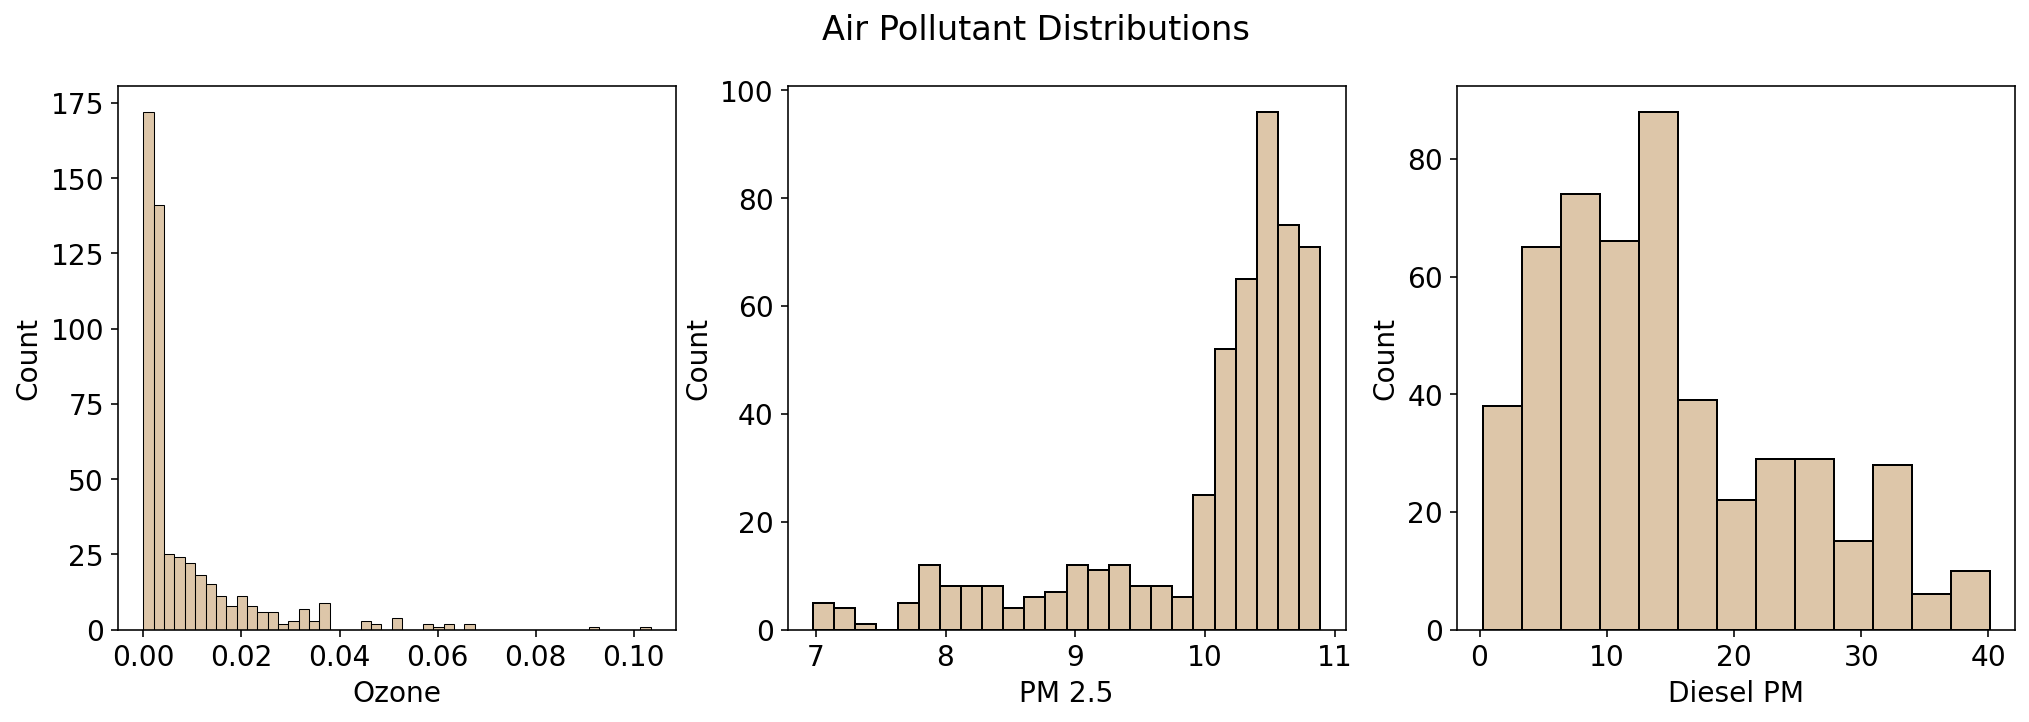

In [19]:
f,ax = plt.subplots(1,3)
f.suptitle('Air Pollutant Distributions')

sns.histplot(df['ozone'], color='tan', ax=ax[0])
ax[0].set(xlabel='Ozone')

sns.histplot(df['pm2.5'], color='tan',ax=ax[1])
ax[1].set(xlabel='PM 2.5')

sns.histplot(df['diesel'], color='tan',ax=ax[2])
_ = ax[2].set(xlabel='Diesel PM')

Each air pollutant measurement provided in the CalEnviroScreen dataset is on a different scale! 
My research pertains more to an overall "score" of air quality per community, so I will first normalize each air pollutant measurement so they are on the same scale, then average all three to get an Air Pollutant Score.

In [20]:
def normalize_column(col):
    return (col - col.min()) / (col.max() - col.min())
    
df[['ozone', 'pm2.5', 'diesel']] = df[['ozone', 'pm2.5', 'diesel']].apply(lambda x: normalize_column(x))

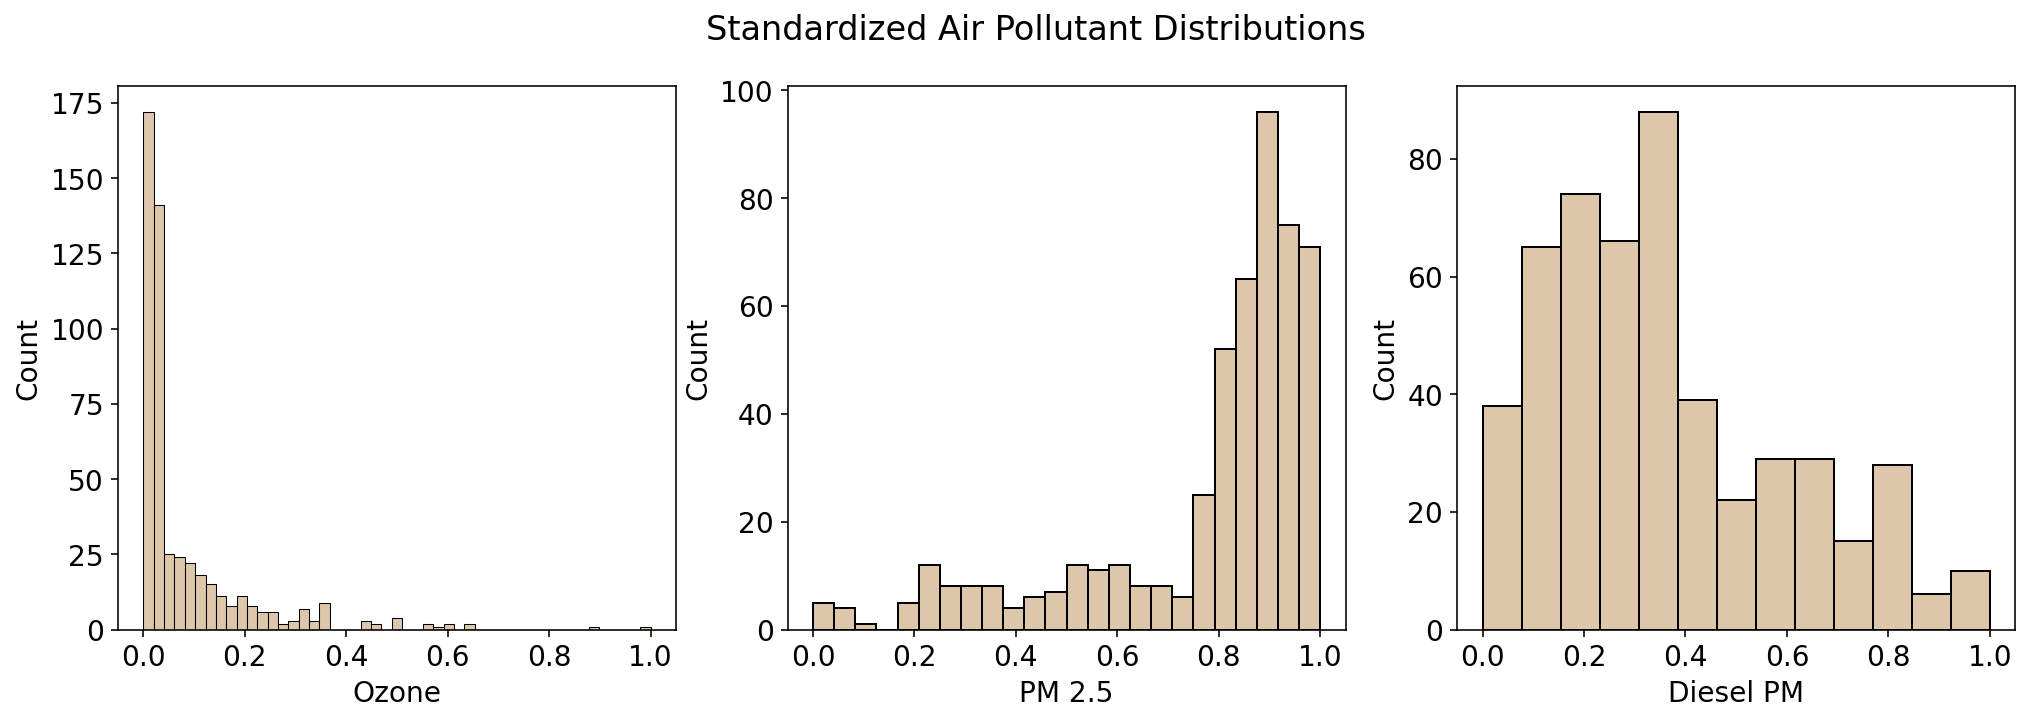

In [21]:
f,ax = plt.subplots(1,3)
f.suptitle('Standardized Air Pollutant Distributions')

sns.histplot(df['ozone'], color='tan', ax=ax[0])
ax[0].set(xlabel='Ozone')

sns.histplot(df['pm2.5'], color='tan',ax=ax[1])
ax[1].set(xlabel='PM 2.5')

sns.histplot(df['diesel'], color='tan',ax=ax[2])
_ = ax[2].set(xlabel='Diesel PM')

The shape of each measurement has been preserved, and they are now on a standard scale from 0 to 1. \
Ozone and PM 2.5 are highly skewed right and left respectively, but since I will be taking the average of all three of these measurements, it would be unwise to transform these to make them more normally distributed.

In [22]:
# calculate Air Pollutant Score on a scale from 0 - 1
df['air_score'] = df[['ozone', 'pm2.5', 'diesel']].apply(lambda x: x.mean(), axis = 1)

In [23]:
# don't need original air pollutant measurements anymore
df.drop(columns=['ozone', 'pm2.5', 'diesel'], inplace=True)

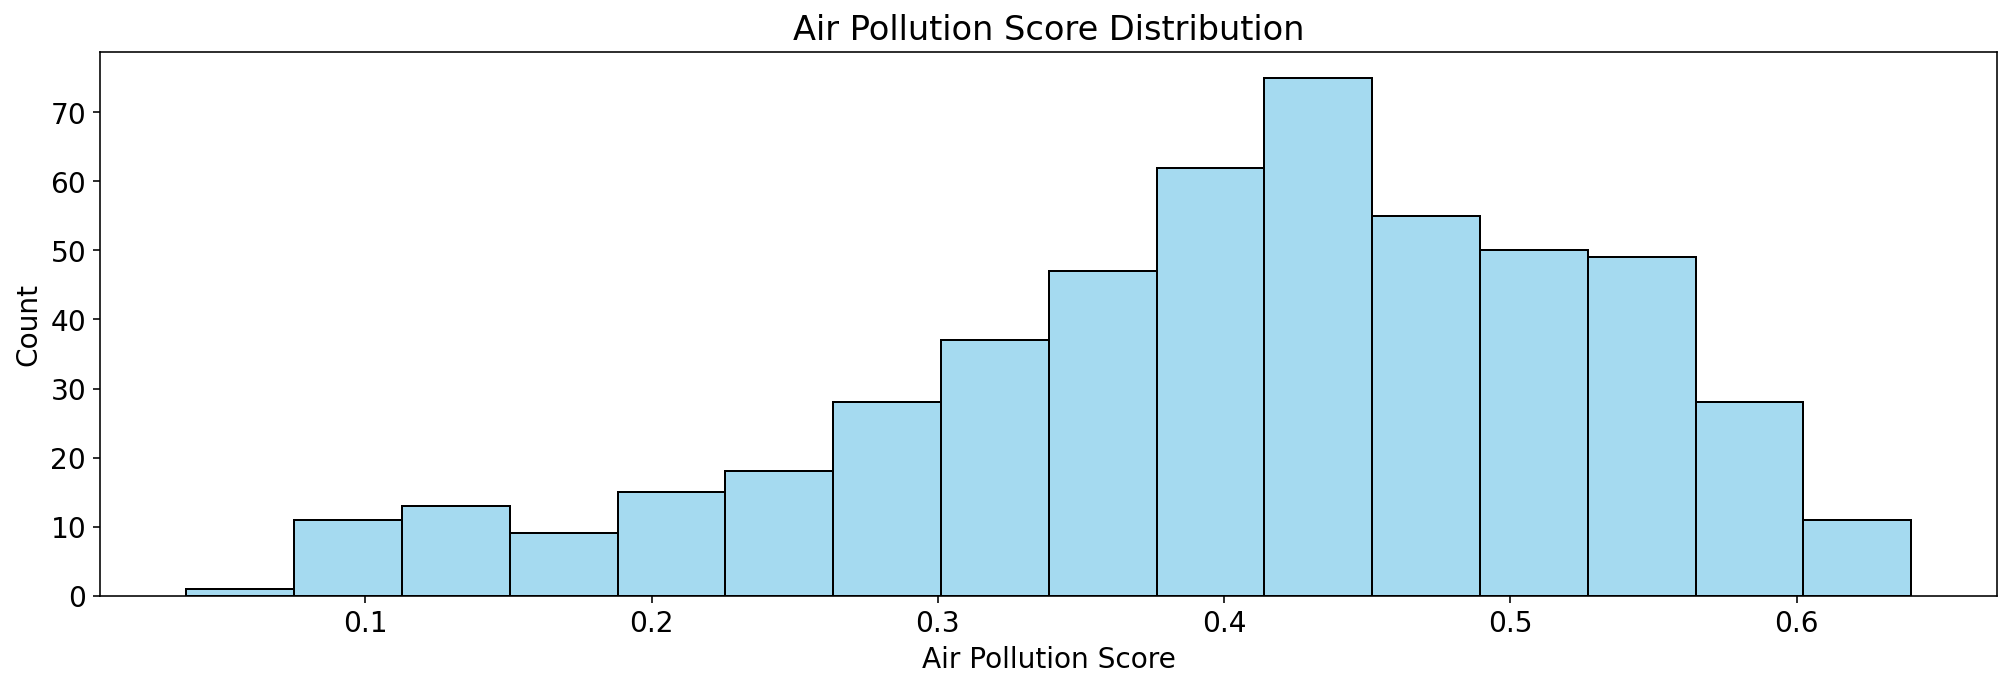

In [24]:
f,ax = plt.subplots()
sns.histplot(df['air_score'], color='skyblue', ax=ax)
_ = ax.set(xlabel='Air Pollution Score', 
           Title='Air Pollution Score Distribution')

Air Pollution Score is left-skewed - this may cause problems with my analysis and is important to note.

#### Transforming Park Acres

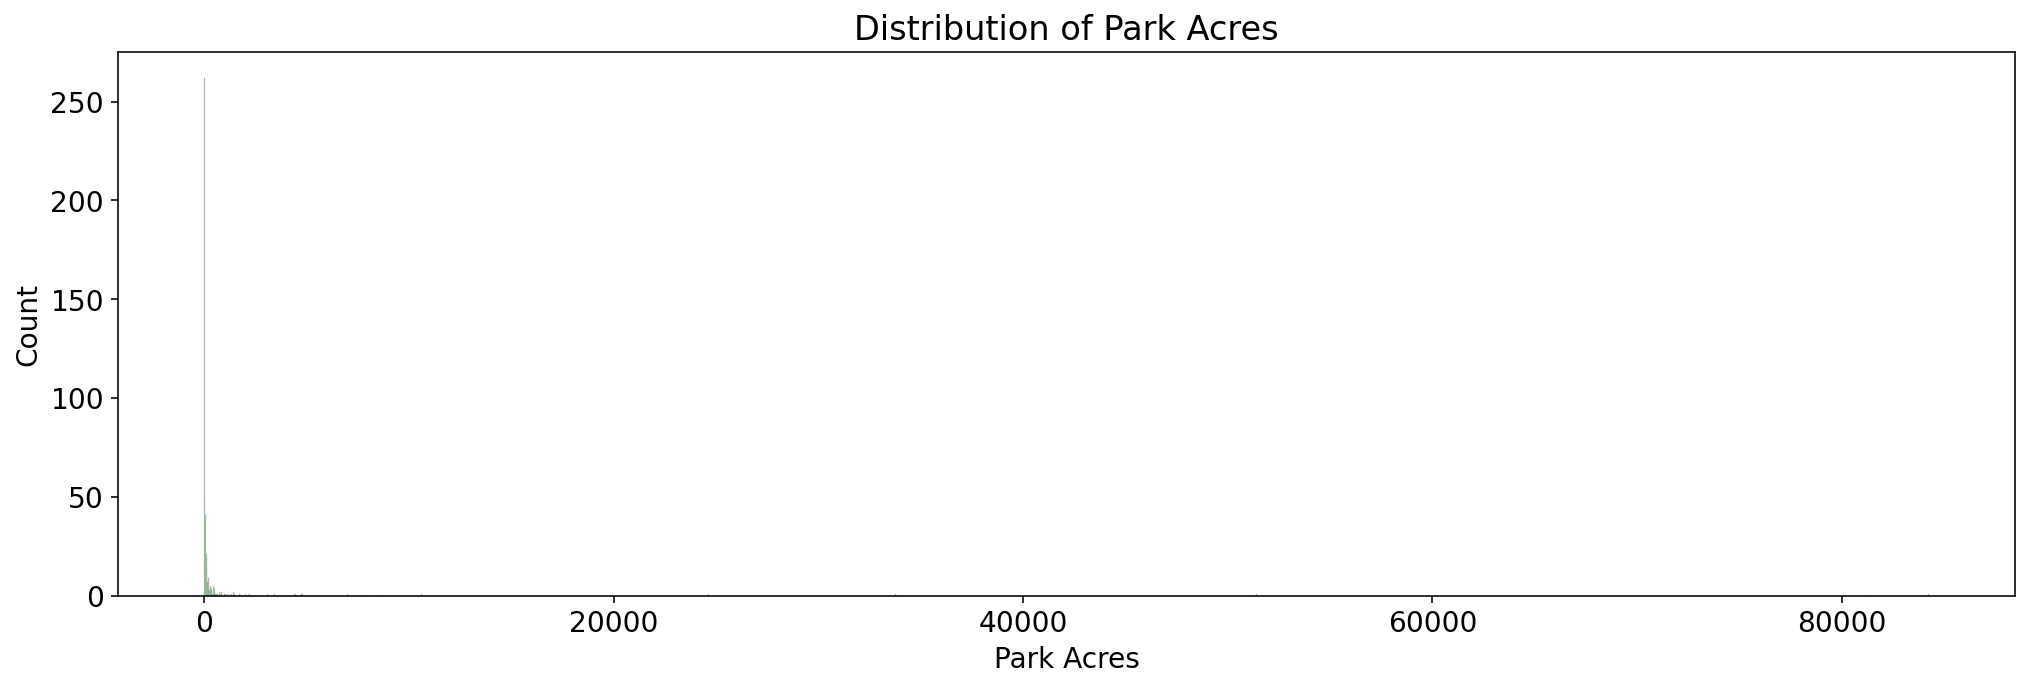

In [25]:
f,ax = plt.subplots()
sns.histplot(df['park_acres'], color='darkseagreen', ax=ax)
_ = ax.set(xlabel='Park Acres', 
          Title='Distribution of Park Acres')

This *very informative* visualization shows me that the distribution of acres of park land per census tract is *heavily* right-skewed. This could be due to many factors, including varying census tract size, as well as urban areas with little park land, and rural areas containing large amounts of park land. \
This distribution can be normalized by performing a logarithmic transformation.

In [26]:
# create a new column to hold log(park_acres) values
df = df.assign(park_acres10 = df['park_acres'])
df['park_acres10'] = np.log10(df['park_acres10'])

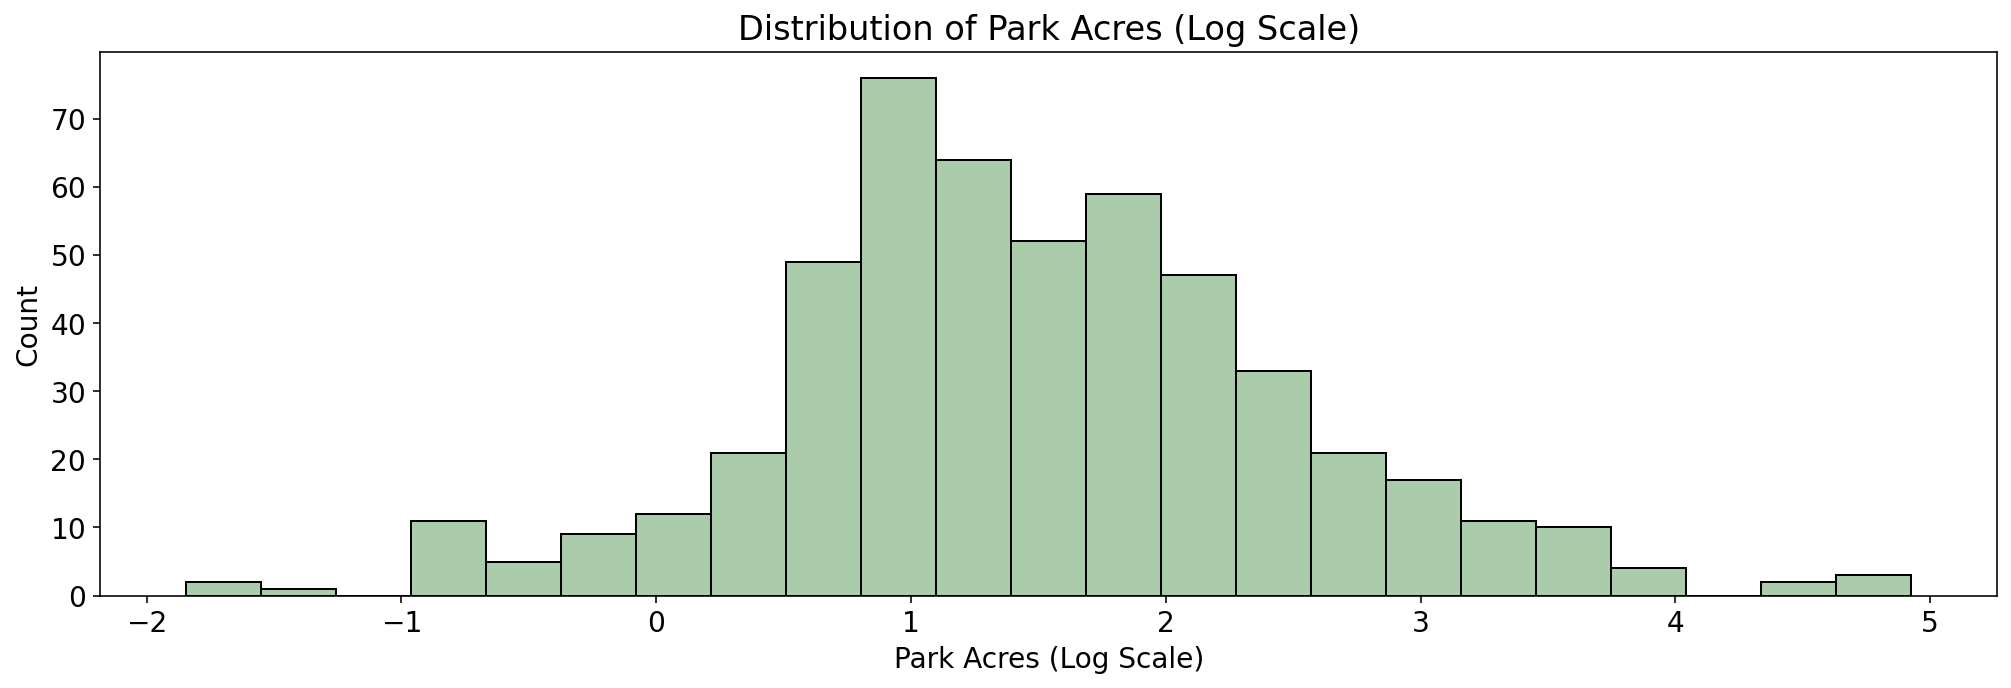

In [27]:
f,ax = plt.subplots()
sns.histplot(df['park_acres10'], color='darkseagreen', ax=ax)
_ = ax.set(xlabel='Park Acres (Log Scale)', 
          Title='Distribution of Park Acres (Log Scale)')

Park acres now follows an approximately normal distribution, which is much easier to work with and analyze.

# Data Analysis & Results

### Exploratory Analysis

#### Distributions

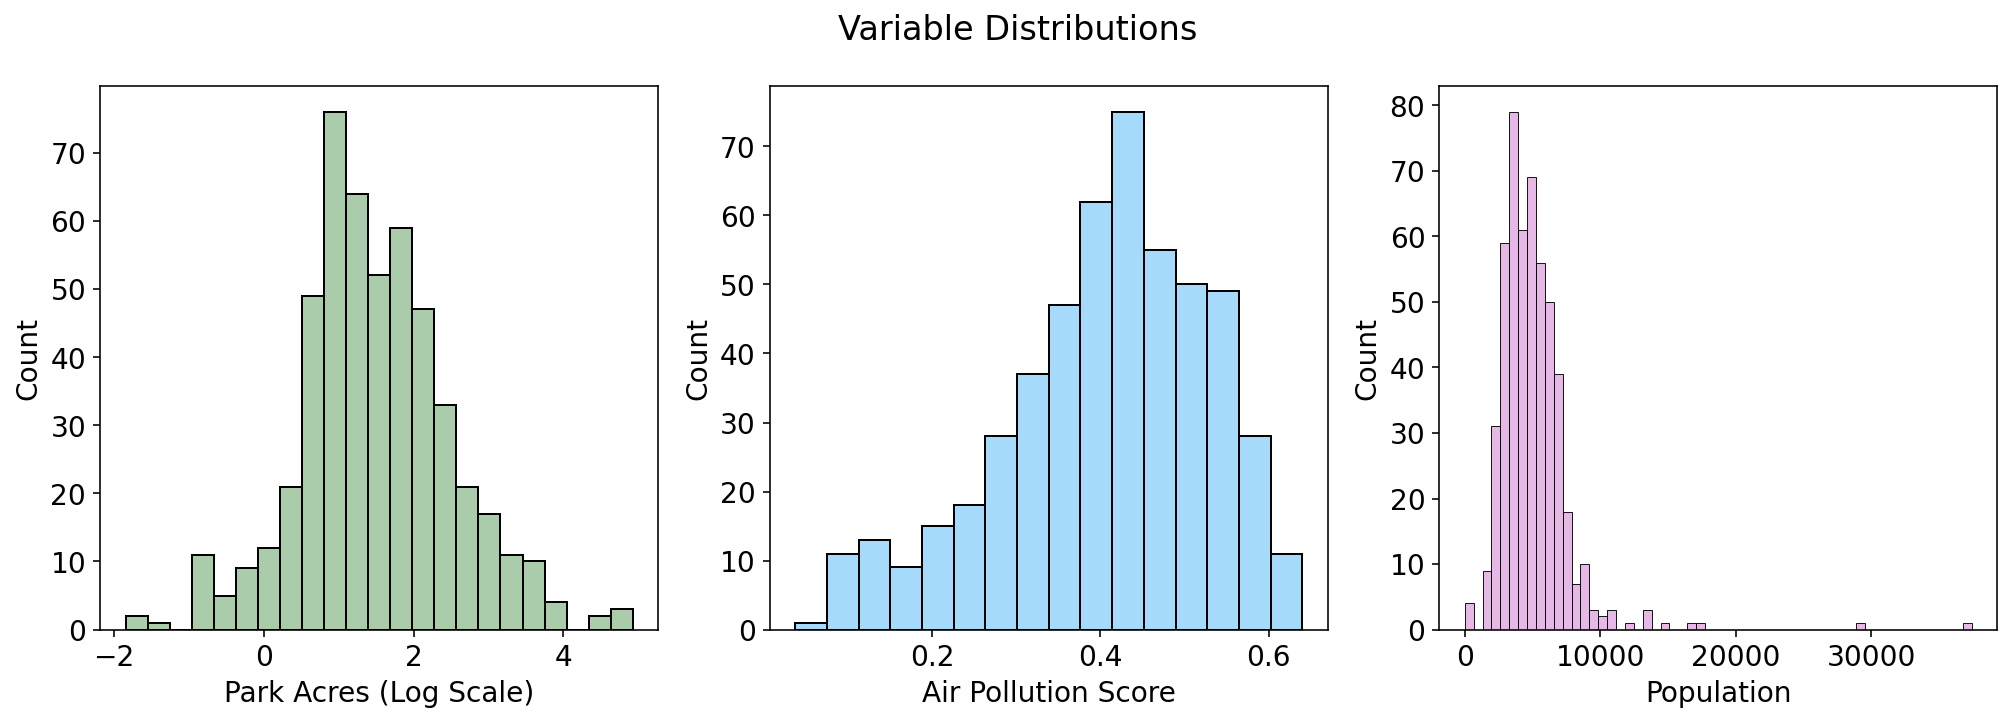

In [28]:
f,ax = plt.subplots(1,3)
f.suptitle('Variable Distributions')

sns.histplot(df['park_acres10'], color='darkseagreen', ax=ax[0])
ax[0].set(xlabel='Park Acres (Log Scale)')

sns.histplot(df['air_score'], color='lightskyblue',ax=ax[1])
ax[1].set(xlabel='Air Pollution Score')

sns.histplot(df['population'], color='plum',ax=ax[2])
_ = ax[2].set(xlabel='Population')

As explored in the previous section, some transformations were required to redistribute the park acres and air pollutant variabes. The distributions of each relevant variable are now somewhat normal, though Air Pollutant Score looks left-skewed. Population is included because it is often a confounding variable in analysis. There are some outliers in population, however, removing these would affect the outcome of my analsis so they will remain.

#### Relationships

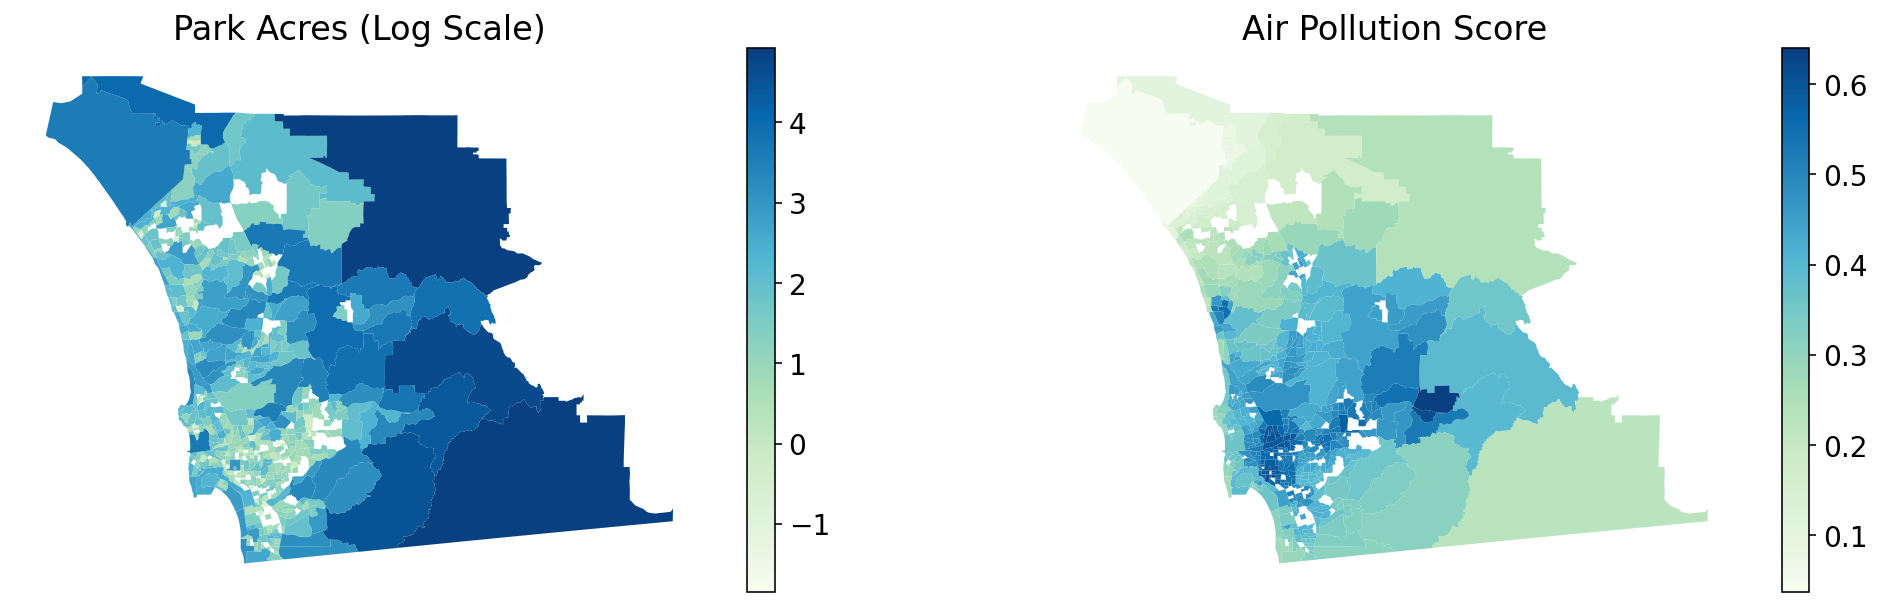

In [29]:
gdf = census_geo.merge(df, on='census_tract')
f,ax = plt.subplots(1,2)

gdf.plot(column='park_acres10', ax=ax[0], cmap='GnBu', legend=True)
ax[0].set_title("Park Acres (Log Scale)")

gdf.plot(column='air_score', ax=ax[1], cmap='GnBu', legend=True)
ax[1].set_title("Air Pollution Score")

ax[0].axis('off')
_ = ax[1].axis('off')

*Note: White areas indicate census tracts with 0 acres of park land.*

The GeoJSON data gives a good way to quickly visualize any relationships between the two variables of interest. These maps suggest that a negative relationship between park acres and Air Pollution Score may exist.

Let's examine this further with a scatter plot between these two variables:

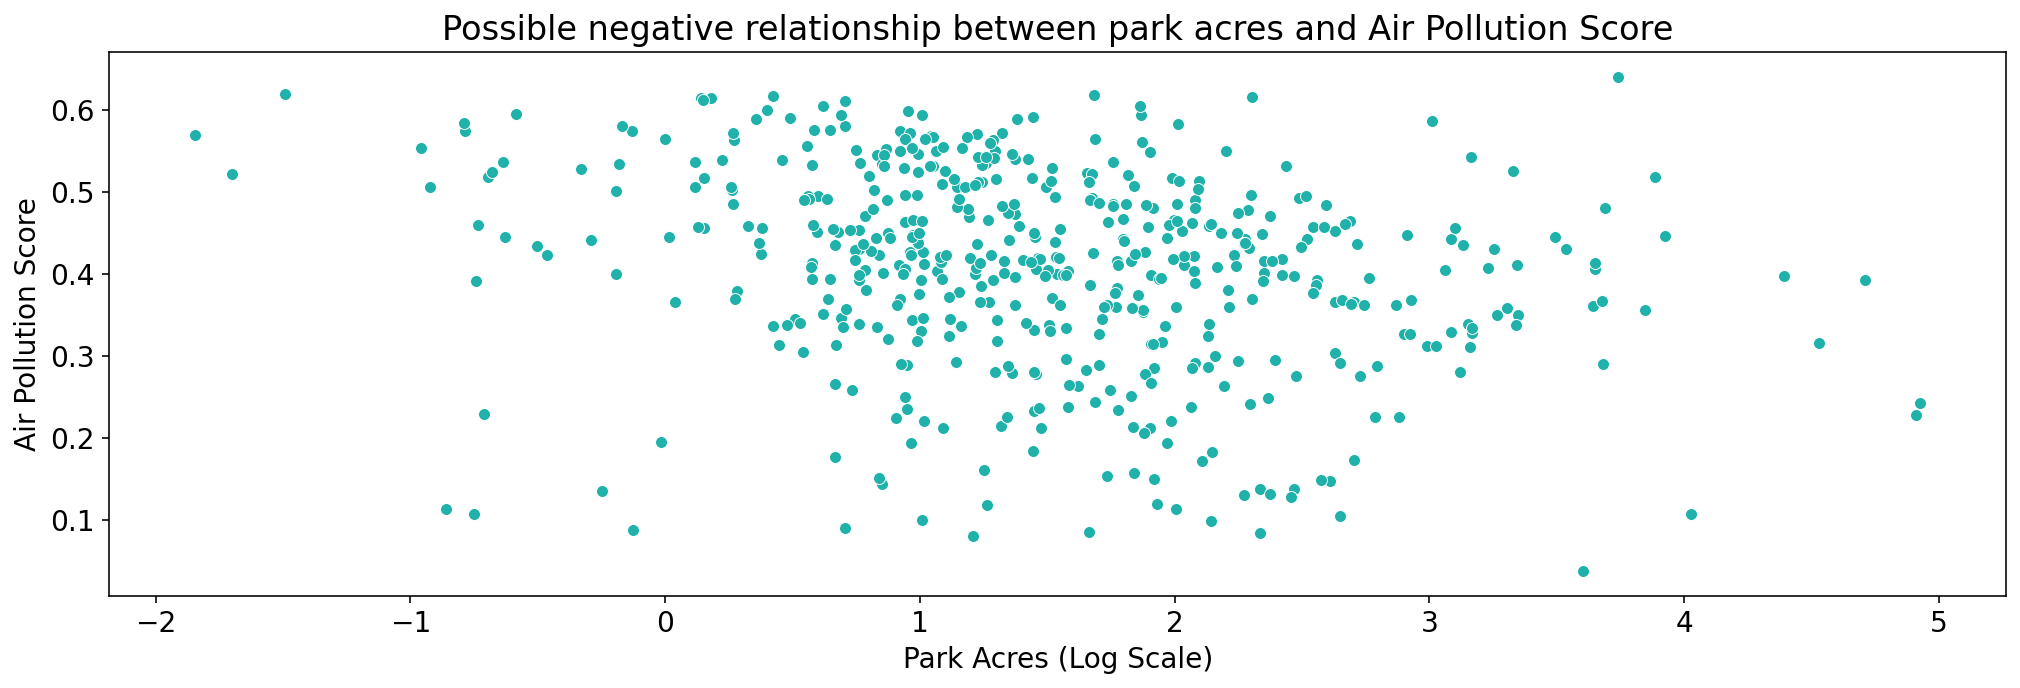

In [30]:
sns.scatterplot(data=df, x='park_acres10', y='air_score', color='lightseagreen')
plt.title('Possible negative relationship between park acres and Air Pollution Score')
plt.ylabel('Air Pollution Score')
_ = plt.xlabel('Park Acres (Log Scale)')

While this visualization does suggest that there is some negative correlation between park acres and Air Pollution Score, it does not show a very strong one.

There do not seem to be any extreme outliers that would affect this distribution, either.

Before performing inferential analysis, I want to check that population is not a confounding variable on Air Pollution Score, because intuitively, one may think that areas with higher populations would have higher average air pollution scores.

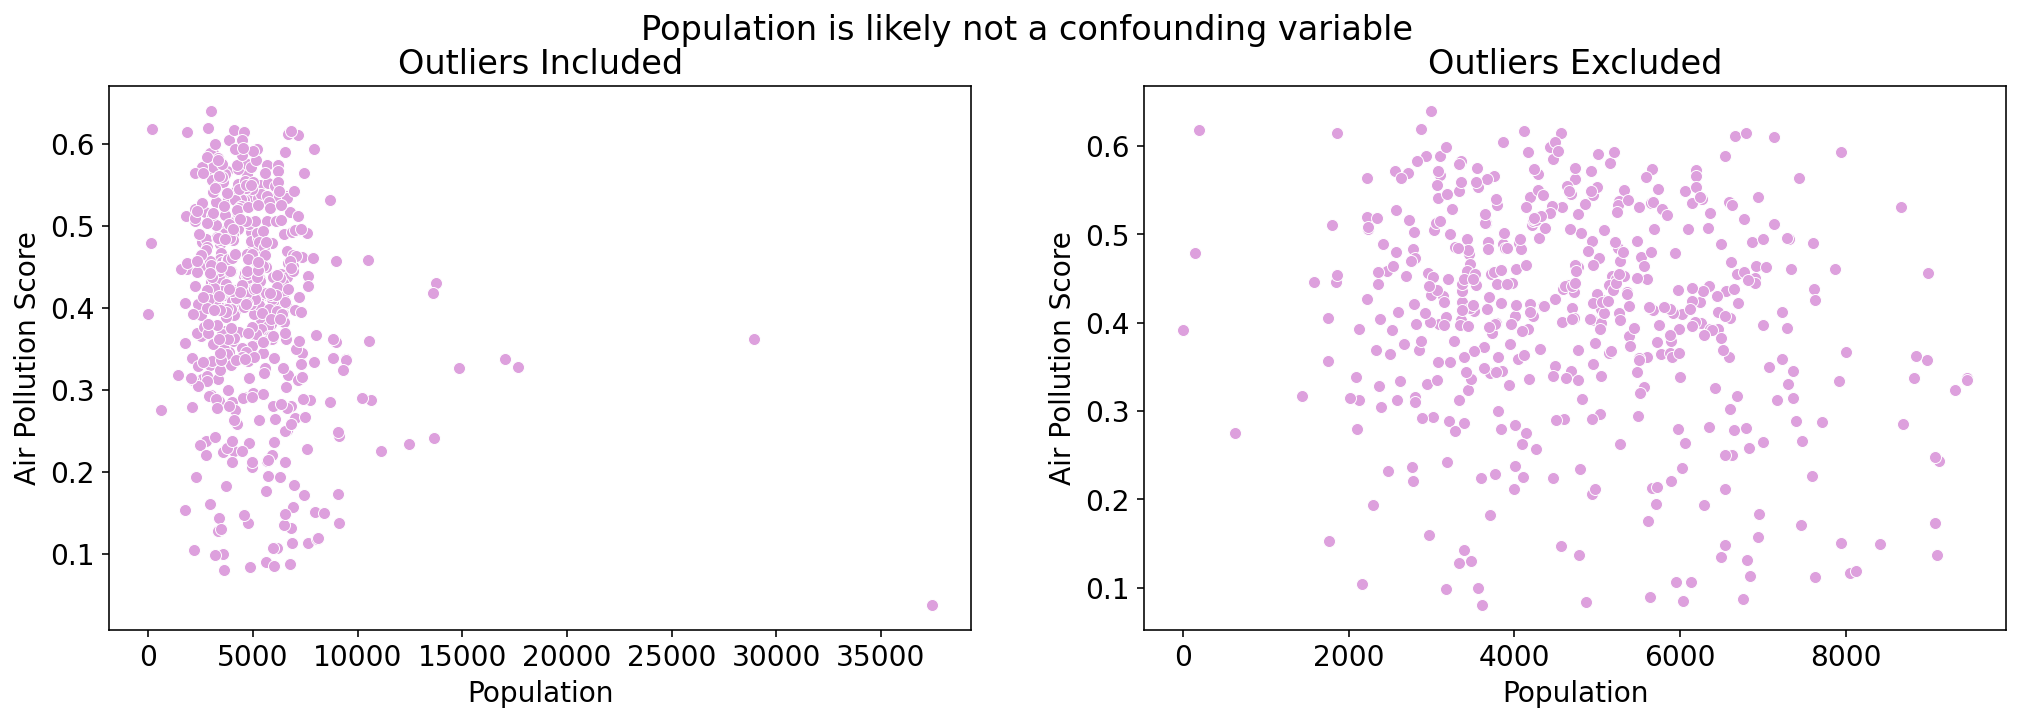

In [31]:
f,ax = plt.subplots(1, 2)
f.suptitle('Population is likely not a confounding variable')

sns.scatterplot(x='population', y='air_score', data=df, color='plum', ax=ax[0])
ax[0].set(xlabel='Population', 
          ylabel='Air Pollution Score',
          title='Outliers Included')

pop_q1 = df['population'].quantile(0.25)
pop_q3 = df['population'].quantile(0.75)
pop_iqr = pop_q3 - pop_q1
sns.scatterplot(x='population', y='air_score', 
                data=df[df['population'].between((pop_q1 - 1.5 * pop_iqr), (pop_q3 + 1.5 * pop_iqr))], 
                color='plum', ax=ax[1])
_ = ax[1].set(xlabel='Population',
              ylabel='Air Pollution Score',
              title='Outliers Excluded')

Based on this visualization, population does not seem to have any relationship with Air Pollution Score, with or without outliers. Thus, I can continue with a simple linear regression to analyze the relationship between park acres and Air Pollution Score.

### Inferential Analysis - Regression

#### Assumptions
Simple linear regression assumes:
1. Linear relationship between variables
2. Multivariate normality
4. No auto-correlation
5. Homoscedasticity

As seen above, there is a somewhat linear relationship between park acres and Air Pollution Score. It may not be strong enough to consider this assumption satisfied, however.

Now to examine normality, I will perform normal tests with an alpha of 0.001:

In [32]:
air = df['air_score'].values
acre = df['park_acres10'].values

st_air, p_air = stats.normaltest(air)
st_acre, p_acre = stats.normaltest(acre)
print(f'Park Acres (Log Scale) \n Statistic: {st_acre}, P-value: {p_acre}')
print(f'Air Pollution Score \n Statistic: {st_air}, P-value: {p_air}')

Park Acres (Log Scale) 
 Statistic: 11.163316735494597, P-value: 0.0037663144025686774
Air Pollution Score 
 Statistic: 29.04381215418422, P-value: 4.934195171975192e-07


The p-value of park acres (log scaled) is > alpha, so this variable follows a normal distribution. \
However, the p-value of Air Pollution Score is < alpha, so it is not considered normally distributed and this assumption is __not__ satisfied.

The observations could possibly be auto-correlated, since census tracts are geographically close to each other, and may share similar Air Pollution Scores.

The data *could* be considered homoscedastic, since they are fairly evenly spaced throughout, but there is some indcation that observations near both extremes of park acres stray away from the best fit line, implying that the data is not homoscedastic.

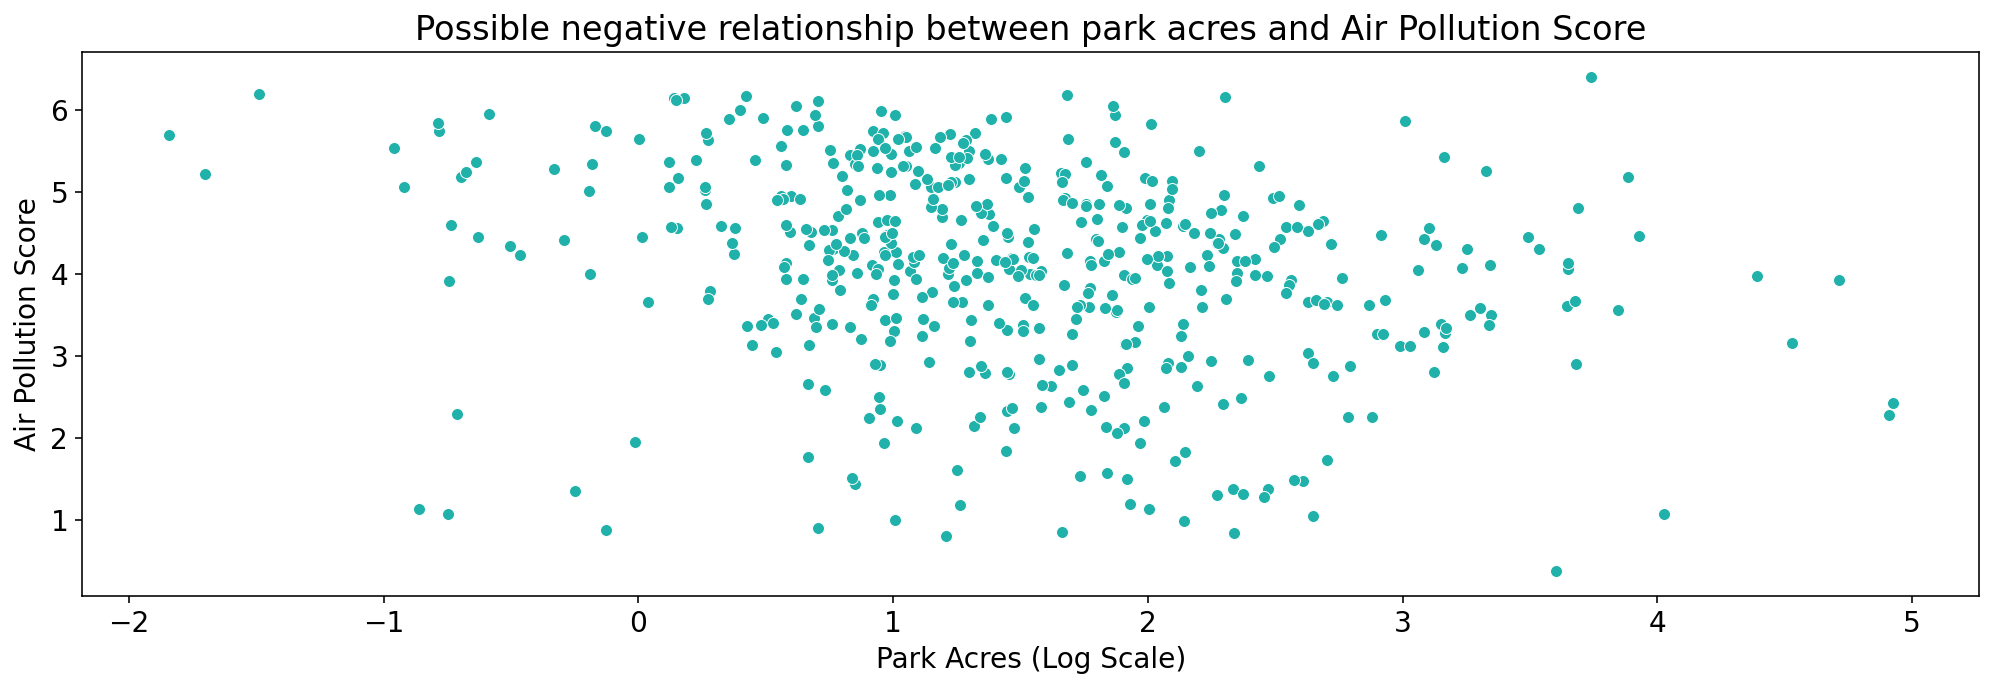

Since multiple assumptions of linear regression are violated, the model produced by regression on this data cannot be considered conclusive. However, for the sake of completeness and interest in the outcome, I will continue with a linear regression.

#### Simple Linear Regression

In [33]:
# predict air pollution score from park acres
out, pred = patsy.dmatrices('air_score ~ park_acres10', df)
mod = sm.OLS(out, pred)
res = mod.fit()

In [34]:
print(res.summary())
print('\nCorrelation: ', stats.pearsonr(df['air_score'],df['park_acres10'])[0])

                            OLS Regression Results                            
Dep. Variable:              air_score   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     34.91
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           6.35e-09
Time:                        22:34:49   Log-Likelihood:                 364.92
No. Observations:                 509   AIC:                            -725.8
Df Residuals:                     507   BIC:                            -717.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.4519      0.009     48.289   

As expected from the assumptions, the model does not perform well. The distrbution of the residuals is fairly skewed, indicating that the model is not high quality. Additionally, with an R-squared of 0.064, only approximately 6.4% of variance in Air Pollution Scores can be explained by park acres.

However, the p-value is very small, and a coefficient of -0.306 is not insignificant. Additionally, the Pearson correlation of approx. -0.254 is somewhat significant. This suggests that there may be some negative relationship between these variables, but perhaps a linear regression was not the correct model to choose.

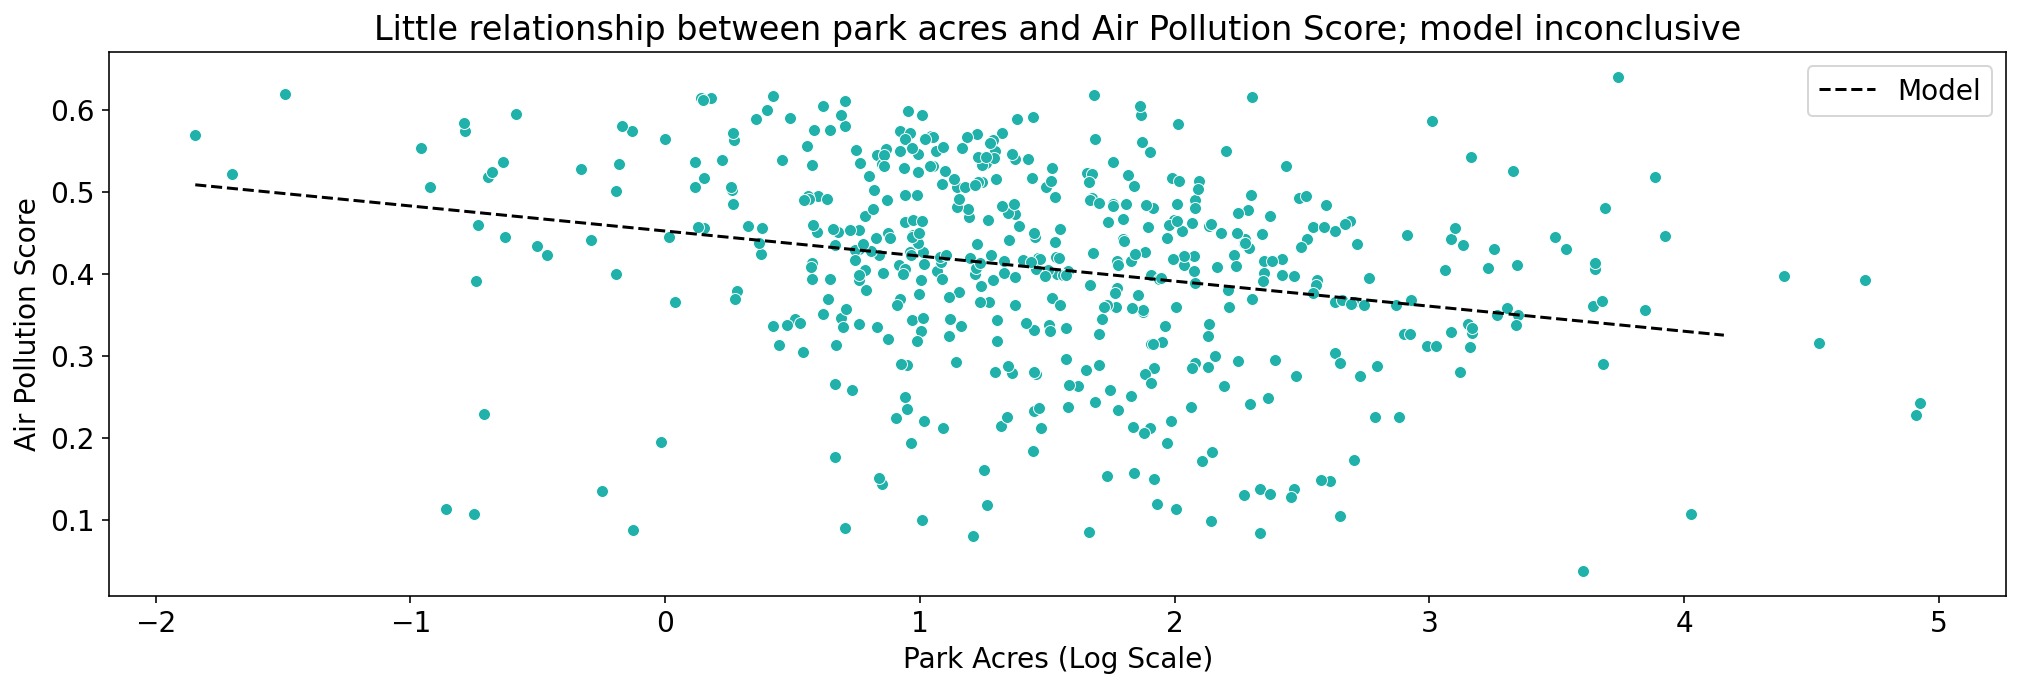

In [35]:
sns.scatterplot(data=df, x='park_acres10', y='air_score', color='lightseagreen')
xs = np.arange(df['park_acres10'].min(), df['park_acres10'].max())
ys = res.params[1] * xs + res.params[0]
plt.ylabel('Air Pollution Score')
plt.xlabel('Park Acres (Log Scale)')
plt.title('Little relationship between park acres and Air Pollution Score; model inconclusive')
plt.plot(xs, ys, '--k', label='Model')
_ = plt.legend()

As expected, the regression line does imply a slight negative correlation, but clearly does not explain a large portion of the data.

# Ethics & Privacy

Two datasets used, the CalEnviroScreen 2.0 and San Diego Census Tracts, are readily available to the public and do not require express permission to download and use in research. The Parks by Census Tract data is also publicly available, but does include a Terms of Use agreement before it can be downloaded, which can be found [here](https://www.openicpsr.org/openicpsr/project/117921/version/V1/download/terms?path=/openicpsr/117921/fcr:versions/V1.2&type=project). However, these terms mostly pertain to data involving research subjects, which the Parks by Census Tract data does not. It also specifies that if the data are used in any publication they must be cited accordingly, which I adhered to by citing the source of the dataset at the beginning of this project.

While none of the datasets include explicitly personal information, there is one consideration - some census tracts have as few as 2 people living in them. Thus, there could be some concern over privacy, however, the only information used in this analysis on these census tracts was pertaining to air pollutants and park acreage, neither of which could identify individuals living in the census tract. 

Since all of the data included in this analysis is objective and quantifiable, collection bias should not be of concern.

This research could have unintended results pertaining to socioeconomic status of communities relating to park availability and quality of life, specifically air quality. Not including communities with zero parks could worsen this unintended affect, making it more important to clarify what this project is measuring. While this is an important topic, it is not the focus of this study, and is not mentioned at any other point in the analysis. Only air quality and park acreage are considered, and the intended purpose is not to analyze the socioeconomic impact of park locations.

# Conclusion & Discussion

It is reasonable to conclude that per census tract in San Diego, park acreage does not have a *significant* impact on average air pollutant measurements. There is evidence to show *some* impact, as seen by the correlation of about -0.25, low p-value, and coefficient, but this must be taken lightly due to the data failing many of the assumptions of linear regression.

There are some limitations to this analysis. "Air Pollution Score" was a somewhat arbitrary calculation, based off of three data points reported in the CalEnviroScreen data. It may be advantageous to find Air Quality Index (AQI) data by San Diego census tract, and conduct further analysis with that information. Additionally, the park acres variable was absolute, instead of a relative calculation based on census tract size - this may have had adverse effects on the outcome, since census tracts in San Diego vary widely in total acreage. The exclusion of tracts with 0 acres of parks is another point to consider; including these communities could have led to more insight into the impact of park acreage on air quality. Parks also vary widely in their make, with some having significantly more foliage and vegetation than others, which could also have impacted the result.

Future analyses on this topic would benefit from using more granular data on parks, such as types of vegetation and quantity, as well as utilizing different models to interpret the relationship between these parks and the air quality of their communities. While the results of my analysis are not conclusive, they do not suggest that there is absolutely no relationship between park acreage and air quality per San Diego community.

Based on my analysis, I would not immediately advise San Diego Parks and Recreation to increase acres of park land per community for the sole purpose of decreasing air pollution burden - I would instead suggest that more extensive research be done on the topic, and focus on how we could improve existing parks to most efficiently filter air pollutants. There are likely many other benefits to increasing the acreage of park land in San Diego communities as well; perhaps decreasing air pollution would be a welcome side-effect.